### Question 3 : Variational AutoEncoder for MNIST Fashion

Epoch 1, Loss: 300.7841
Epoch 2, Loss: 271.5429
Epoch 3, Loss: 265.9154
Epoch 4, Loss: 262.5591
Epoch 5, Loss: 259.9989
Epoch 6, Loss: 258.3780
Epoch 7, Loss: 256.8288
Epoch 8, Loss: 255.4298
Epoch 9, Loss: 255.0108
Epoch 10, Loss: 253.9207


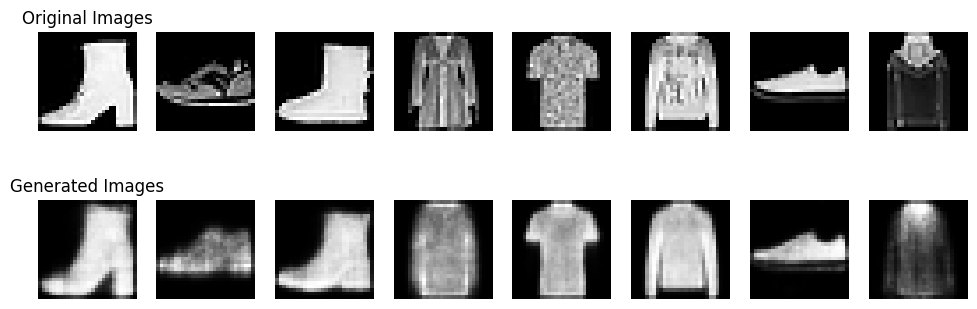

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load FashionMNIST dataset
(fX_train, fy_train), (fX_test, fy_test) = fashion_mnist.load_data()
fX_train, fX_test = fX_train / 255.0, fX_test / 255.0  # Normalize
fX_train, fX_test = np.array(fX_train), np.array(fX_test)

# Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.transform(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Create test dataset and dataloader
fashion_test_dataset = FashionMNISTDataset(fX_test, fy_test)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=16, shuffle=True)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.Tanh(),
            nn.Linear(256, 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def forward(self, x):
        params = self.encoder(x)
        mu, logvar = params[:, :self.latent_dim], params[:, self.latent_dim:]
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return self.decoder(z), mu, logvar

# Loss function
def vae_loss_fn(reconstruction, X, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(reconstruction, X.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for X, _ in fashion_test_loader:
        X = X.to(device)
        optimizer.zero_grad()
        recon_X, mu, logvar = vae(X)
        loss = vae_loss_fn(recon_X, X, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(fashion_test_loader.dataset):.4f}")

# Generate reconstructed images
vae.eval()
original_images, _ = next(iter(fashion_test_loader))  # Get a batch of test images
original_images = original_images.to(device)
reconstructed_images, _, _ = vae(original_images)
original_images = original_images.cpu().detach().numpy()
reconstructed_images = reconstructed_images.cpu().detach().numpy()

# Function to plot original and generated images
def compare_images(original, generated, num_images=8):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(generated[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Generated Images", fontsize=12)
    plt.show()

# Show original vs reconstructed images
compare_images(original_images, reconstructed_images)


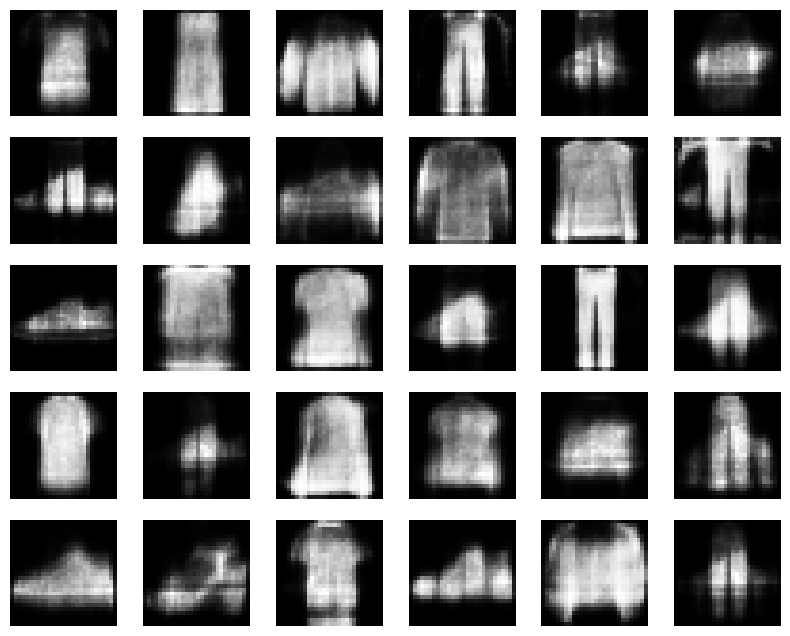

In [6]:
vae.eval()
z = torch.randn(30, vae.latent_dim).to(device)
generated_samples = vae.decoder(z).cpu().detach().numpy()

# Function to plot generated images
import matplotlib.pyplot as plt

def plot_images(images, n_rows=5, n_cols=6):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

plot_images(generated_samples)